In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import gammainc

from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

In [2]:
snap = 122
nbins = 10
bin = 6
r = HBTReader("./data/")

### Subhalo mass function

In [3]:
ss = r.LoadSubhalos(snap)
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[28966 26091 21066 14867  9900  6122  3670  2285  1300   782   463   265
   172    75    49    31    11     8     3     4] [ 1.30103     1.55091011  1.80079023  2.05067035  2.30055047  2.55043059
  2.80031071  3.05019083  3.30007095  3.54995107  3.79983119  4.04971131
  4.29959143  4.54947155  4.79935167  5.04923178  5.2991119   5.54899202
  5.79887214  6.04875226  6.29863238] [ 1.42597006  1.67585017  1.92573029  2.17561041  2.42549053  2.67537065
  2.92525077  3.17513089  3.42501101  3.67489113  3.92477125  4.17465137
  4.42453149  4.67441161  4.92429173  5.17417184  5.42405196  5.67393208
  5.9238122   6.17369232]


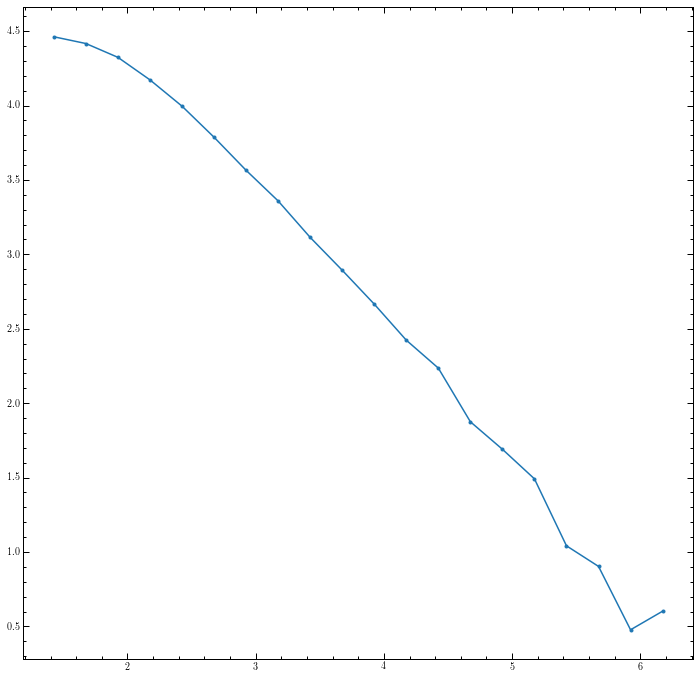

In [4]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [13]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit','CenterOffset']]
hs = hs[(hs['M200Crit'] >= 20) & (hs['CenterOffset'] >= 0.1)]
hs['M200Crit'] = 1e10*hs['M200Crit']

counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin',\
    np.digitize(np.log10(hs['M200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[1041  576  331  177   95   42   26   13    4    4] [ 11.3013382   11.61355515  11.92577209  12.23798904  12.55020599
  12.86242294  13.17463989  13.48685684  13.79907379  14.11129074
  14.42350769] [ 11.45744667  11.76966362  12.08188057  12.39409752  12.70631447
  13.01853142  13.33074837  13.64296532  13.95518227  14.26739922]


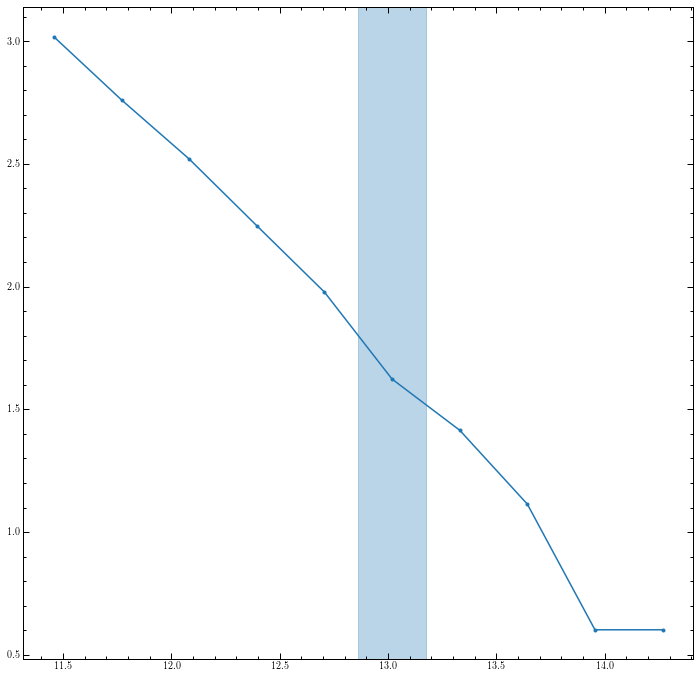

In [14]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='C0', alpha=0.3)

### Concentration - mass relation

In [7]:
hs = hs[hs['bin'] == bin]

### Density profile

In [8]:
def prof:
    ps = np.array(r.LoadHostHalos(snap, [list(hs['HaloId']),])['Profile'],\
        dtype=np.float)
    xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
    particles = np.sum(ps, axis=1)
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    p = np.median(ps, axis=0)
    x = np.linspace(-2.0, 0.0, 20)
    vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))

    xmax = 0.8
    idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))

    c, a, chi2 = einasto.fit(p, lambda c, a: einasto.m(np.power(10.0, x), c, a),\
        np.linspace(1.0, 10.0, 100), np.linspace(0.01, 0.99, 100))
    rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))

    c_nfw, chi2_nfw = nfw.fit(p, lambda c: nfw.m(np.power(10.0, x), c),\
        np.linspace(1.0, 10.0, 100))
    rho_s_nfw = np.log10(nfw.rho_enc(1.0/c, c))

     print chi2, chi2_nfw

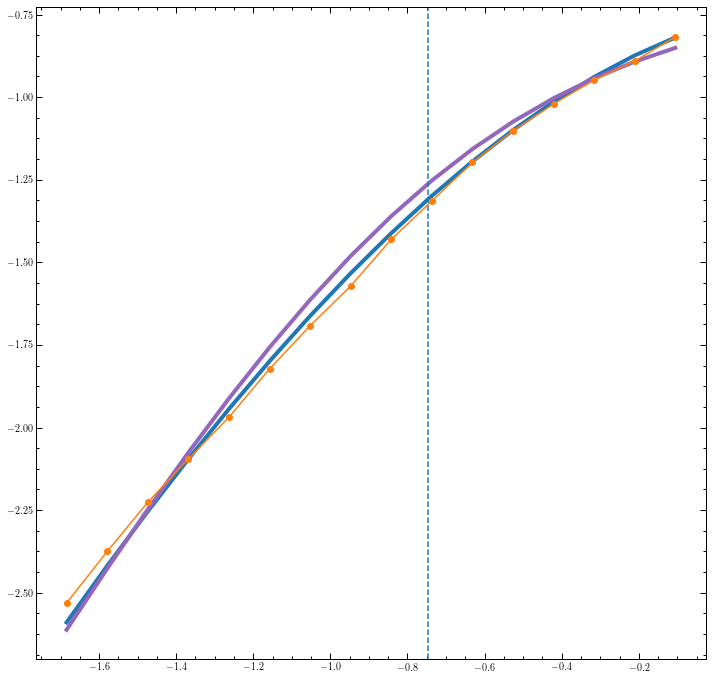

In [12]:
plt.plot(x[idx], np.log10(einasto.m(np.power(10.,x), c, a)[idx]),\
    color='C0', linewidth=4, zorder=1)

plt.plot(x[idx], np.log10(nfw.m(np.power(10.,x), c_nfw)[idx]),\
    color='C4', linewidth=4, zorder=1)

# [plt.plot(x[1:], np.log10(_[1:]), color='grey', zorder=0) for _ in ps]
plt.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
plt.axvline(np.log10(1.0/c), color='C0', linestyle='--')

### Collapsed Mass History

In [12]:
F = einasto.m_enc(1.0/c, c, a)
print F

0.186277582392


In [82]:
ms = np.array(read.cmh(snap).loc[hs['HaloId']], dtype=np.float)
ms = np.divide(ms.T, ms[:,-1]).T
m = np.mean(ms, axis=0)

zs = read.snaps()
# np.genfromtxt('./output/hbtp/redshift_list.txt',\
#     dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))
rho = cosmology.rho_c(\
    np.array([zs[zs['Snapshot'] == s][0]['Redshift']\
    for s in np.arange(1+snap-ms.shape[1], 1+snap)]))\
    / cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

In [83]:
m_f = F*m[-1]
y1, y2 = m[m > m_f][0], m[m < m_f][-1]
x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

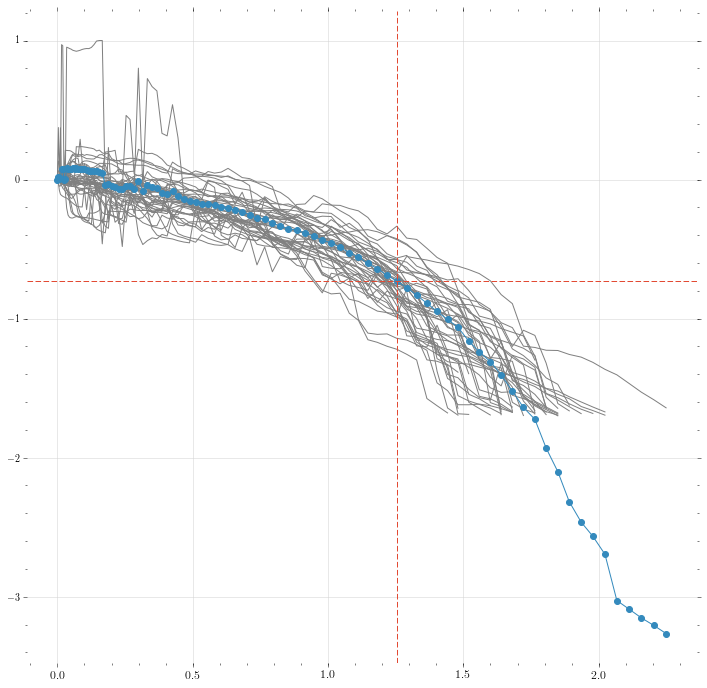

In [84]:
[plt.plot(np.log10(rho), np.log10(_), color='grey') for _ in ms]
plt.plot(np.log10(rho), np.log10(m),\
    color='C1', marker='o')
plt.axhline(np.log10(m_f), color='C0', linestyle='--')
plt.axvline(rho_f, color='C0', linestyle='--')

### Density - density relation

After the analysis above has been done for all mass bins, for all snapshots, we can start plotting the density - density relation.

In [85]:
rho_f, rho_s

(1.2533600209571729, 3.8144964526305327)

In [59]:
ds = {g: np.genfromtxt('/gpfs/data/dc-oles1/merger_trees/output/%s/einasto.csv'%g,\
    delimiter=',', skip_header=1, dtype=np.dtype([\
    ('snap',int),\
    ('bin',int),\
    ('rho_f',float),\
    ('rho_s',float),\
])) for g in ['gr', 'fr']}

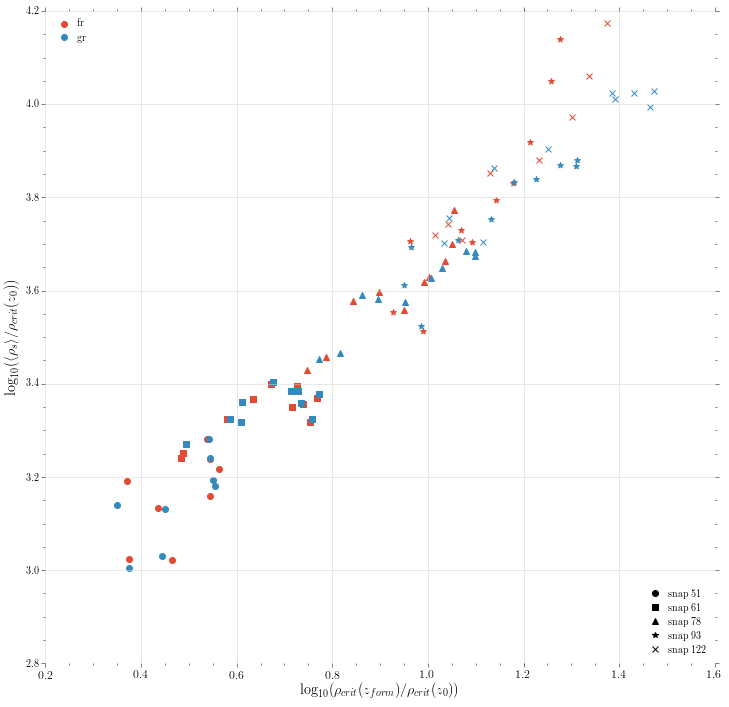

In [60]:
markers = [['o', None], ['s', None], ['^', None], ['*', None], ['x', None]]
colours = [['C0', None], ['C1', None]]

for i,snap in enumerate(np.unique(ds['gr']['snap'])):
    for j,g in enumerate(ds):
        for d in ds[g][ds[g]['snap'] == snap]:
            plt.scatter(d['rho_f'], d['rho_s'],\
                color=colours[j][0], marker=markers[i][0])
            markers[i][1] = plt.Line2D([], [], label='snap %d'%snap,\
                color='k', marker=markers[i][0], linestyle='')
        colours[j][1] = plt.Line2D([], [], label=g,\
            color=colours[j][0], marker='o', linestyle='')

# plt.plot(np.linspace(0.2, 1.6), 2.65+np.linspace(0.2, 1.6), 'k--')

plt.xlabel(r'$\log_{10}(\rho_{crit}(z_{form})/\rho_{crit}(z_0))$')
plt.ylabel(r'$\log_{10}(\langle\rho_{s}\rangle/\rho_{crit}(z_0))$')
plt.xlim((0.2, 1.6))
plt.ylim((2.8, 4.2))

l1 = plt.legend(handles=[markers[i][1] for i in range(len(markers))], loc='lower right')
l2 = plt.legend(handles=[colours[j][1] for j in range(len(colours))], loc='upper left')
plt.gca().add_artist(l1)